# Tarea 4: Programación Genética

## 4.1 Tabla de verdad con F1 = {and, or, not}


Encontrar las funciones que hacen cierta la tabla de verdad anexa.
Con el propósito de observar el impacto de una buena selección en el conjunto de funciones, se usarán dos F1 = {and, or, not}, F2 = {and, or, not, xor} y el conjunto terminal  T = {A, B, C, [0, 1]}. Donde A, B, C, solo los valores de la tabla adjunta, y 0, 1 son constantes opcionales.

In [1]:
import deap
import math
import operator
import random
import functools
import numpy as np
import pandas as pd
from deap import gp, base, creator, tools, algorithms
import plotly.graph_objs as go

# Plotly render svgs
import plotly.io as pio
pio.renderers.default = "svg"

In [2]:
# Cargar tabla de verdad desde un archivo CSV
tabla = pd.read_csv('data/Paridad.csv')

In [3]:
tabla

,A,B,C,S
0,0,0,0,1
1,0,0,1,0
2,0,1,0,0
3,0,1,1,1
4,1,0,0,0
5,1,0,1,1
6,1,1,0,1
7,1,1,1,0


In [4]:
POP_SIZE = 200
N_GEN = 40
CXPB = 0.8   # probabilidad de cruzamiento
MUTPB = 0.2  # probabilidad de mutación
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

In [5]:

# Primitivas con tres variables A,B,C
pset = gp.PrimitiveSet("MAIN", 3)
pset.renameArguments(ARG0='A')
pset.renameArguments(ARG1='B')
pset.renameArguments(ARG2='C')

# Funciones
pset.addPrimitive(operator.and_, 2)
pset.addPrimitive(operator.or_, 2)
pset.addPrimitive(operator.not_, 1)

# Terminales constantes
pset.addTerminal(0)
pset.addTerminal(1)

# Fitness
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

# Toolbox
toolbox = base.Toolbox()
toolbox.register("expr", gp.genFull, pset=pset, min_=1, max_=3)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

def evalParity(individual):
    """
    Evaluar el individuo en la tabla de verdad.
    El error es la suma de los errores cuadráticos.
    """
    func = toolbox.compile(expr=individual)
    errors = (
        (func(row.A, row.B, row.C) - row.S)**2
        for _, row in tabla.iterrows()
    )
    return math.fsum(errors),

toolbox.register("evaluate", evalParity) # Evaluación del individuo
toolbox.register("select", tools.selTournament, tournsize=3) # Selección por torneo
toolbox.register("mate", gp.cxOnePoint) # Cruce de un punto
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2) # Mutación
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

# Limitar altura
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=6))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=6))

In [6]:
# Ejecutar evolución con F1 (and, or, not)

# Estadísticas y registro del mejor
stats = tools.Statistics(lambda ind: ind.fitness.values[0])
stats.register("min", min)
stats.register("avg", np.mean)
stats.register("std", np.std)

hof = tools.HallOfFame(1) # Mejor individuo

pop = toolbox.population(n=POP_SIZE) # Población inicial

pop, log = algorithms.eaSimple(pop, toolbox, cxpb=CXPB, mutpb=MUTPB, ngen=N_GEN, 
                               stats=stats, halloffame=hof, verbose=True)

best = hof[0]
print("Mejor individuo F1:", best)
print("Altura:", best.height)
print("Fitness (SSE):", best.fitness.values[0])

# Calcular exactitud F1
func_best = toolbox.compile(expr=best)
aciertos = 0
for _, row in tabla.iterrows():
    pred = func_best(row.A, row.B, row.C)
    aciertos += int(pred == row.S)
accuracy = aciertos / len(tabla)
print(f"Exactitud F1: {accuracy:.3f}")

# Mostrar log en un DataFrame
log_df = pd.DataFrame(log)
log_df.tail()

gen	nevals	min	avg  	std     
0  	200   	3  	3.995	0.212073
1  	172   	3  	3.965	0.231894
2  	167   	3  	3.93 	0.339264
3  	162   	3  	3.87 	0.364829
4  	170   	3  	3.855	0.392396
5  	181   	2  	3.725	0.509289
6  	172   	2  	3.555	0.571817
7  	167   	2  	3.395	0.590741
8  	169   	2  	3.3  	0.632456
9  	164   	2  	3.105	0.658768
10 	176   	2  	3.035	0.695539
11 	164   	2  	2.86 	0.728286
12 	176   	2  	2.77 	0.732871
13 	156   	2  	2.685	0.758798
14 	163   	2  	2.58 	0.695414
15 	164   	2  	2.6  	0.734847
16 	158   	2  	2.64 	0.741889
17 	178   	2  	2.57 	0.724638
18 	165   	2  	2.435	0.660133
19 	179   	2  	2.475	0.706665
20 	166   	2  	2.525	0.699553
21 	155   	2  	2.465	0.669907
22 	163   	2  	2.535	0.72026 
23 	166   	2  	2.5  	0.67082 
24 	175   	2  	2.545	0.691357
25 	174   	2  	2.56 	0.697424
26 	171   	2  	2.605	0.747646
27 	167   	2  	2.51 	0.699929
28 	164   	2  	2.415	0.642476
29 	170   	2  	2.51 	0.721041
30 	153   	2  	2.435	0.675111
31 	172   	2  	2.47 	0.74773 
32 	171   

,gen,nevals,min,avg,std
36,36,164,2.0,2.460,0.662118
37,37,165,2.0,2.410,0.633956
38,38,182,2.0,2.405,0.633226
39,39,157,2.0,2.385,0.605620
40,40,162,2.0,2.425,0.627993


## 4.2 Tabla de verdad con F2 = {and, or, not, xor}

In [7]:
# Definir otro primitive set con XOR
pset2 = gp.PrimitiveSet("MAIN", 3)
pset2.renameArguments(ARG0='A')
pset2.renameArguments(ARG1='B')
pset2.renameArguments(ARG2='C')
pset2.addPrimitive(operator.and_, 2)
pset2.addPrimitive(operator.or_, 2)
pset2.addPrimitive(operator.not_, 1)
pset2.addPrimitive(operator.xor, 2)  # agregado
pset2.addTerminal(0)
pset2.addTerminal(1)

# Otro toolbox 
creator.create("FitnessMin2", base.Fitness, weights=(-1.0,))
creator.create("Individual2", gp.PrimitiveTree, fitness=creator.FitnessMin2)

toolbox2 = base.Toolbox()
toolbox2.register("expr", gp.genFull, pset=pset2, min_=1, max_=3)
toolbox2.register("individual", tools.initIterate, creator.Individual2, toolbox2.expr)
toolbox2.register("population", tools.initRepeat, list, toolbox2.individual)
toolbox2.register("compile", gp.compile, pset=pset2)

def evalParity2(individual):
    """
    Evaluar el individuo en la tabla de verdad usando toolbox2.
    """
    func = toolbox2.compile(expr=individual)
    errors = (
        (func(row.A, row.B, row.C) - row.S)**2
        for _, row in tabla.iterrows()
    )
    return math.fsum(errors),

toolbox2.register("evaluate", evalParity2) # Misma función de evaluación, pero para evitar errores
toolbox2.register("select", tools.selTournament, tournsize=3)
toolbox2.register("mate", gp.cxOnePoint)
toolbox2.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox2.register("mutate", gp.mutUniform, expr=toolbox2.expr_mut, pset=pset2)
toolbox2.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=5))
toolbox2.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=5))

stats2 = tools.Statistics(lambda ind: ind.fitness.values[0])
stats2.register("min", min)
stats2.register("avg", np.mean)
stats2.register("std", np.std)

hof2 = tools.HallOfFame(1)

pop2 = toolbox2.population(n=POP_SIZE)

pop2, log2 = algorithms.eaSimple(pop2, toolbox2, cxpb=CXPB, mutpb=MUTPB, ngen=N_GEN,
                                 stats=stats2, halloffame=hof2, verbose=True)

best2 = hof2[0]
print("Mejor individuo F2:", best2)
print("Altura:", best2.height)
print("Fitness (SSE):", best2.fitness.values[0])

func_best2 = toolbox2.compile(expr=best2)
aciertos2 = sum(int(func_best2(r.A, r.B, r.C) == r.S) for _, r in tabla.iterrows())
accuracy2 = aciertos2 / len(tabla)
print(f"Exactitud F2: {accuracy2:.3f}")

log2_df = pd.DataFrame(log2)
log2_df.tail()

gen	nevals	min	avg  	std     
0  	200   	2  	4.035	0.551158
1  	177   	0  	3.915	0.466664
2  	171   	0  	3.89 	0.712671
3  	175   	0  	3.95 	0.739932
4  	181   	0  	3.835	0.926161
5  	164   	0  	3.75 	0.864581
6  	169   	0  	3.755	0.935401
7  	170   	0  	3.635	1.04965 
8  	174   	0  	3.485	1.0999  
9  	175   	0  	3.425	1.11552 
10 	173   	0  	3.24 	1.29707 
11 	163   	0  	2.955	1.46047 
12 	172   	0  	2.89 	1.59308 
13 	159   	0  	2.71 	1.68104 
14 	160   	0  	2.435	1.72214 
15 	169   	0  	2.25 	1.67854 
16 	162   	0  	2.325	1.75766 
17 	171   	0  	2.5  	1.71756 
18 	164   	0  	2.555	1.70205 
19 	175   	0  	2.435	1.67803 
20 	159   	0  	2.15 	1.73421 
21 	173   	0  	2.205	1.81741 
22 	170   	0  	2.355	1.83548 
23 	160   	0  	2    	1.81108 
24 	169   	0  	2.175	1.82054 
25 	160   	0  	2.105	1.80941 
26 	159   	0  	1.93 	1.848   
27 	162   	0  	1.98 	1.85462 
28 	154   	0  	1.9  	1.8412  
29 	168   	0  	1.955	1.82564 
30 	167   	0  	2.135	1.88063 
31 	162   	0  	1.95 	1.84323 
32 	161   

,gen,nevals,min,avg,std
36,36,173,0.0,1.820,1.810414
37,37,168,0.0,2.150,1.840516
38,38,175,0.0,2.240,1.879468
39,39,176,0.0,1.825,1.836947
40,40,174,0.0,1.785,1.899678


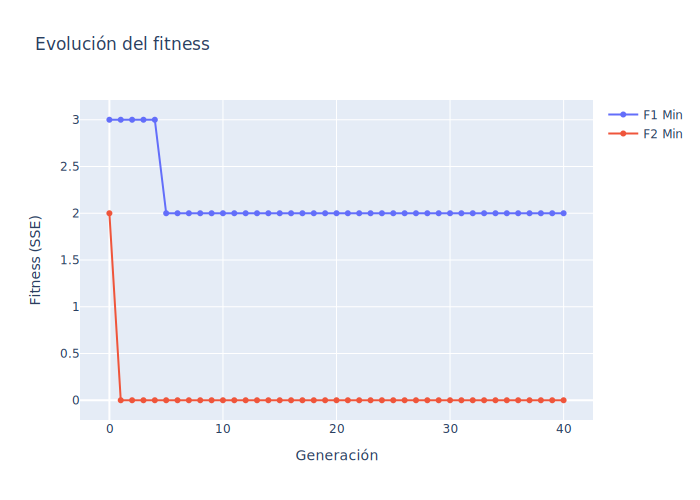

In [8]:
# Plot fitness

fig = go.Figure()
fig.add_trace(go.Scatter(y=log_df['min'], mode='lines+markers', name='F1 Min'))
fig.add_trace(go.Scatter(y=log2_df['min'], mode='lines+markers', name='F2 Min'))
fig.update_layout(title='Evolución del fitness',
                  xaxis_title='Generación',
                  yaxis_title='Fitness (SSE)')
fig.show()

Comparando los entre el uso de F1 = {and, or, not} y F2 = {and, or, not, xor}, encontramos que el uso de F2 mejora significativamente la capacidad del modelo para ajustarse a la tabla de verdad dada. 

Por lo que observamos que la elección del conjunto de funciones tiene un impacto crucial en la eficacia del modelo de programación genética.


## Regresión simbólica con la tabla anexa

Adjunto al presente se incluye la tabla de valores. Para este caso el conjunto de funciones es F = {+, -, *, div, cos, sin, log, exp, abs, sqrt, x^y, ...} sientanse en  libertad de incluir o quitar las funciones según lo crean conveniente. 
A su vez, el conjunto terminal queda definido por  T= {x, y, R, k's}. 
Donde x, y son los valores tomado de la tabla, R el conjunto de reales (recuerden que los pueden generar incluso con aleatorios), y k  son constantes que ustedes consideren que pueden funcionar, (pi, e, ...)


## A

In [9]:
clase = pd.read_csv('data/Reg_Sybol_Class.csv')
clase.columns = ['x', 'f']

In [10]:
clase.head()

,x,f
0,-10,4.85
1,-9,-3.20
2,-8,2.80
3,-7,1.30
4,-6,4.10


In [11]:
# Protected primitive functions

def protectedDiv(a, b):
    return a / b if abs(b) > 1e-9 else a

def protectedLog(a):
    a = float(a)
    return math.log(abs(a)) if abs(a) > 1e-9 else 0.0

def protectedSqrt(a):
    return math.sqrt(abs(a))

def protectedExp(a):
    a = max(min(a, 50), -50)
    return math.exp(a)

def protectedPow(a, b):
    try:
        if abs(a) > 1e6 or abs(b) > 8:
            return 1.0
        return float(pow(a, int(b)))
    except Exception:
        return 1.0


In [12]:

# Funciones y terminales
pset_sym = gp.PrimitiveSet("MAIN", 1)  # x
pset_sym.renameArguments(ARG0='x')

# Operadores aritméticos
pset_sym.addPrimitive(operator.add, 2)
pset_sym.addPrimitive(operator.sub, 2)
pset_sym.addPrimitive(operator.mul, 2)
pset_sym.addPrimitive(protectedDiv, 2)

# Trig 
pset_sym.addPrimitive(math.sin, 1)
pset_sym.addPrimitive(math.cos, 1)
pset_sym.addPrimitive(protectedLog, 1)
pset_sym.addPrimitive(protectedExp, 1)
pset_sym.addPrimitive(abs, 1)
pset_sym.addPrimitive(protectedSqrt, 1)
pset_sym.addPrimitive(protectedPow, 2)

# Constantes
pset_sym.addTerminal(math.pi, name="pi")
pset_sym.addTerminal(math.e, name="e")
pset_sym.addEphemeralConstant("rand", lambda: random.uniform(-10, 10))

#  Clases Fitness / Individuo 
try:
    creator.FitnessMinSymb
except AttributeError:
    creator.create("FitnessMinSymb", base.Fitness, weights=(-1.0,))
try:
    creator.IndividualSymb
except AttributeError:
    creator.create("IndividualSymb", gp.PrimitiveTree, fitness=creator.FitnessMinSymb)

#  Toolbox 
toolbox_sym = base.Toolbox()
toolbox_sym.register("expr", gp.genHalfAndHalf, pset=pset_sym, min_=1, max_=3)
toolbox_sym.register("individual", tools.initIterate, creator.IndividualSymb, toolbox_sym.expr)
toolbox_sym.register("population", tools.initRepeat, list, toolbox_sym.individual)
toolbox_sym.register("compile", gp.compile, pset=pset_sym)


/Users/roicort/GitHub/PCIC/Genetics/GeneticProgramming/.venv/lib/python3.13/site-packages/deap/gp.py:257: RuntimeWarning:

Ephemeral rand function cannot be pickled because its generating function is a lambda function. Use functools.partial instead.



In [13]:
# Función de evaluación para regresión simbólica (ajuste a f(x))
def evalSymbolic(individual):
    func = toolbox_sym.compile(expr=individual)
    try:
        errors = ((func(row['x']) - row['f'])**2 for _, row in clase.iterrows())
        return (math.fsum(errors),)
    except (ValueError, OverflowError, ZeroDivisionError):
        return (1e10,)

toolbox_sym.register("evaluate", evalSymbolic)
toolbox_sym.register("select", tools.selTournament, tournsize=3)
toolbox_sym.register("mate", gp.cxOnePoint)
toolbox_sym.register("expr_mut", gp.genHalfAndHalf, min_=0, max_=2)
toolbox_sym.register("mutate", gp.mutUniform, expr=toolbox_sym.expr_mut, pset=pset_sym)

# Limitar altura de los árboles
toolbox_sym.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=10))
toolbox_sym.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=10))

In [14]:
# Ejecutar evolución

POP_SIZE = 200
N_GEN = 40
CXPB = 0.8
MUTPB = 0.2
random.seed(42)

# Estadísticas multi: fitness y tamaño
hof = tools.HallOfFame(1)
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", min)
mstats.register("max", max)

pop = toolbox_sym.population(n=POP_SIZE)

pop, log = algorithms.eaSimple(pop, toolbox_sym, cxpb=CXPB, mutpb=MUTPB, ngen=N_GEN,
                               stats=mstats, halloffame=hof, verbose=True)

best = hof[0]
print("Mejor individuo:", best)
print("Altura:", best.height)
print("Error cuadrático (SSE):", best.fitness.values[0])

log_df = pd.DataFrame(log)
log_df.tail()

   	      	                                              fitness                                              	                      size                     
   	      	---------------------------------------------------------------------------------------------------	-----------------------------------------------
gen	nevals	avg        	gen	max                     	min                  	nevals	std        	avg 	gen	max	min	nevals	std    
0  	200   	2.15049e+42	0  	(2.419305433663835e+44,)	(469.76118749420846,)	200   	2.15653e+43	4.42	0  	14 	2  	200   	2.59299
1  	174   	2.2187e+07 	1  	(4426337606.207691,)    	(469.76118749420846,)	174   	3.12203e+08	3.96	1  	14 	1  	174   	2.2646 
2  	163   	2.16675e+67	2  	(4.333504521772235e+69,)	(469.76118749420846,)	163   	3.05658e+68	3.825	2  	12 	1  	163   	2.32258
3  	166   	5.0609e+33 	3  	(1.0121805429499375e+36,)	(457.3328187901389,) 	166   	7.13928e+34	3.505	3  	12 	1  	166   	2.28691
4  	172   	9.712e+24  	4  	(1.942400830668118e+27,) 	(

/var/folders/4w/72wtbysj7kb189x1nn694p9h0000gn/T/ipykernel_11103/1937063526.py:21: RuntimeWarning:

divide by zero encountered in scalar power

/Users/roicort/GitHub/PCIC/Genetics/GeneticProgramming/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:190: RuntimeWarning:

invalid value encountered in subtract



30 	165   	1.81465e+20	30 	(2.073885481050632e+22,) 	(311.4330539799348,) 	165   	1.82407e+21	15.08 	30 	32 	1  	165   	6.05505
31 	182   	3.37015e+20	31 	(4.666234975588674e+22,) 	(313.9954633510754,) 	182   	3.481e+21  	14.39 	31 	28 	1  	182   	6.36065
32 	164   	inf        	32 	(inf,)                   	(313.9954633510754,) 	164   	nan        	15.695	32 	34 	1  	164   	6.67248
33 	167   	5.44394e+20	33 	(1.0887881608963576e+23,)	(307.0280742129721,) 	167   	7.67962e+21	15.625	33 	35 	1  	167   	7.35285
34 	178   	7.79286e+20	34 	(1.0887881608963576e+23,)	(307.34712836032475,)	178   	7.89273e+21	16.195	34 	37 	1  	178   	7.18101
35 	154   	inf        	35 	(inf,)                   	(307.34712836032475,)	154   	nan        	16.29 	35 	37 	1  	154   	7.13133
36 	174   	1.41078e+12	36 	(282155223277796.5,)     	(272.9196644907471,) 	174   	1.99014e+13	17.525	36 	37 	1  	174   	6.81905
37 	183   	1.57315e+20	37 	(2.109358588714731e+22,) 	(272.9196644907471,) 	183   	1.65456e+21	17.205	37 

,gen,nevals
36,36,174
37,37,183
38,38,167
39,39,172
40,40,178


In [15]:
log_df.columns

Index(['gen', 'nevals'], dtype='object')

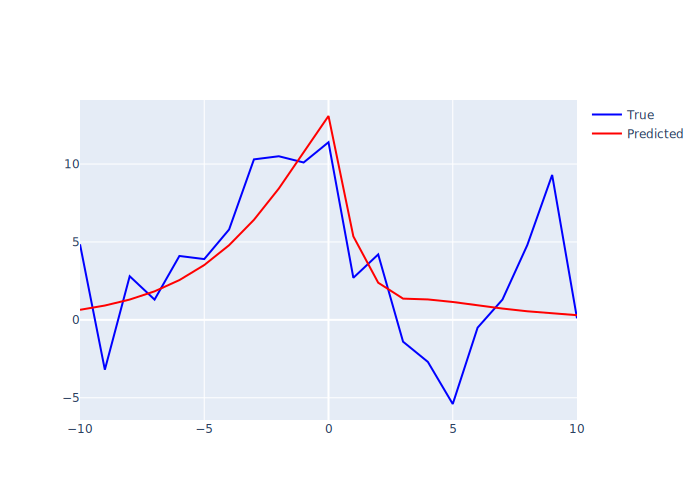

In [16]:
# Plot

x_vals = clase['x']
y_true = clase['f']
func_best = toolbox_sym.compile(expr=best)
y_pred = [func_best(x) for x in x_vals]

fig = go.Figure()
fig.add_trace(go.Scatter(x=x_vals, y=y_true, mode='lines', name='True', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=x_vals, y=y_pred, mode='lines', name='Predicted', line=dict(color='red')))
fig.show()

## B 

In [17]:
symreg = pd.read_csv('data/symbolic_regression.csv')
symreg.columns = ['x', 'y', 'f']
symreg.head()

,x,y,f
0,-100,-100,19.059929
1,-100,-90,86.073703
2,-100,-80,104.763090
3,-100,-70,78.242133
4,-100,-60,22.679452


In [18]:
# Conjunto de funciones y terminales

pset_sym2 = gp.PrimitiveSet("MAIN", 2)  # x, y
pset_sym2.renameArguments(ARG0='x')
pset_sym2.renameArguments(ARG1='y')

# Operadores aritméticos
pset_sym2.addPrimitive(operator.add, 2)
pset_sym2.addPrimitive(operator.sub, 2)
pset_sym2.addPrimitive(operator.mul, 2)
pset_sym2.addPrimitive(protectedDiv, 2)
pset_sym2.addPrimitive(protectedPow, 2)
# Trig 
pset_sym2.addPrimitive(math.sin, 1)
pset_sym2.addPrimitive(math.cos, 1)
pset_sym2.addPrimitive(protectedLog, 1)
pset_sym2.addPrimitive(math.exp, 1)
pset_sym2.addPrimitive(math.exp2, 1)
#pset_sym2.addPrimitive(abs, 1)
pset_sym2.addPrimitive(protectedSqrt, 1)
# Constantes
pset_sym2.addTerminal(math.pi, name="pi")
pset_sym2.addTerminal(math.e, name="e")
pset_sym2.addEphemeralConstant("rand", functools.partial(random.uniform, -100, 100))

# Clases Fitness
try:
    creator.FitnessMinSymb2
except AttributeError:
    creator.create("FitnessMinSymb2", base.Fitness, weights=(-1.0,))
try:
    creator.IndividualSymb2
except AttributeError:
    creator.create("IndividualSymb2", gp.PrimitiveTree, fitness=creator.FitnessMinSymb2)

# Toolbox
toolbox_sym2 = base.Toolbox()
toolbox_sym2.register("expr", gp.genHalfAndHalf, pset=pset_sym2, min_=1, max_=3)
toolbox_sym2.register("individual", tools.initIterate, creator.IndividualSymb2, toolbox_sym2.expr)
toolbox_sym2.register("population", tools.initRepeat, list, toolbox_sym2.individual)
toolbox_sym2.register("compile", gp.compile, pset=pset_sym2)

# Función de evaluación para regresión simbólica (ajuste a f(x,y))
def evalSymbolic2(individual):
    func = toolbox_sym2.compile(expr=individual)
    try:
        errors = ((func(row['x'], row['y']) - row['f'])**2 for _, row in symreg.iterrows())
        return (math.fsum(errors),)
    except (ValueError, OverflowError, ZeroDivisionError):
        # Penalización alta si ocurre error matemático
        return (1e10,)
    
toolbox_sym2.register("evaluate", evalSymbolic2)
toolbox_sym2.register("select", tools.selTournament, tournsize=3)
toolbox_sym2.register("mate", gp.cxOnePoint)
toolbox_sym2.register("expr_mut", gp.genHalfAndHalf, min_=0, max_=2)
toolbox_sym2.register("mutate", gp.mutUniform, expr=toolbox_sym2.expr_mut, pset=pset_sym2)
toolbox_sym2.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=3))
toolbox_sym2.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=3))


In [19]:
# Ejecutar evolución (multivariable) con estadísticas de fitness y tamaño
POP_SIZE = 500
N_GEN = 100
CXPB = 0.8
MUTPB = 0.2
random.seed(42)

hof = tools.HallOfFame(3)

stats_fit2 = tools.Statistics(lambda ind: ind.fitness.values)
stats_size2 = tools.Statistics(len)
mstats2 = tools.MultiStatistics(fitness=stats_fit2, size=stats_size2)
mstats2.register("avg", np.mean)
mstats2.register("std", np.std)
mstats2.register("min", min)
mstats2.register("max", max)

pop2 = toolbox_sym2.population(n=POP_SIZE)

pop2, log2 = algorithms.eaSimple(pop2, toolbox_sym2, cxpb=CXPB, mutpb=MUTPB, ngen=N_GEN,
                                 stats=mstats2, halloffame=hof, verbose=True)

best2 = hof[0]
print("Mejor individuo multivariable:", best2)
print("Altura:", best2.height)
print("Longitud (nodos):", len(best2))
print("Error cuadrático (SSE):", best2.fitness.values[0])

log2_df = pd.DataFrame(log2)
log2_df.tail()

/var/folders/4w/72wtbysj7kb189x1nn694p9h0000gn/T/ipykernel_11103/2475699097.py:47: RuntimeWarning:

overflow encountered in scalar power

/Users/roicort/GitHub/PCIC/Genetics/GeneticProgramming/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:190: RuntimeWarning:

invalid value encountered in subtract

/Users/roicort/GitHub/PCIC/Genetics/GeneticProgramming/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:193: RuntimeWarning:

overflow encountered in multiply

/var/folders/4w/72wtbysj7kb189x1nn694p9h0000gn/T/ipykernel_11103/1937063526.py:21: RuntimeWarning:

divide by zero encountered in scalar power



   	      	                          fitness                          	                      size                     
   	      	-----------------------------------------------------------	-----------------------------------------------
gen	nevals	avg	gen	max   	min                  	nevals	std	avg 	gen	max	min	nevals	std    
0  	500   	inf	0  	(inf,)	(2043019.3055838281,)	500   	nan	4.31	0  	14 	2  	500   	2.50557
1  	439   	1.3668e+198	1  	(6.833999036102657e+200,)	(2053044.3320912262,)	439   	inf	3.746	1  	12 	1  	439   	2.06627
2  	427   	inf        	2  	(inf,)                   	(2053044.3320912262,)	427   	nan	3.522	2  	12 	1  	427   	1.98331
3  	419   	inf        	3  	(inf,)                   	(2051330.2241006324,)	419   	nan	3.28 	3  	10 	1  	419   	1.75659
4  	416   	inf        	4  	(inf,)                   	(2046568.8905938168,)	416   	nan	3.212	4  	10 	1  	416   	1.65259
5  	422   	1.21396e+86	5  	(1.5174544944341143e+88,)	(2045075.67355705,)  	422   	1.35181e+87	3.218	5  	

,gen,nevals
96,96,435
97,97,406
98,98,424
99,99,423
100,100,420


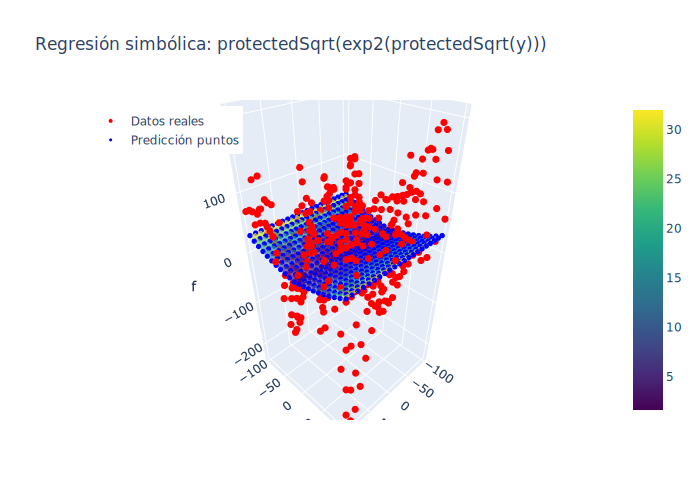

SSE en puntos originales: 2029169.6511734866


In [20]:
# Plot 3D

func_best2 = toolbox_sym2.compile(expr=best2)

# Puntos reales
x_data = symreg['x'].values
y_data = symreg['y'].values
z_true = symreg['f'].values
z_pred_pts = [func_best2(xd, yd) for xd, yd in zip(x_data, y_data)]

# Crear una malla para superficie
nx, ny = 50, 50 
x_lin = np.linspace(x_data.min(), x_data.max(), nx)
y_lin = np.linspace(y_data.min(), y_data.max(), ny)
Xg, Yg = np.meshgrid(x_lin, y_lin)
Zg = np.zeros_like(Xg, dtype=float)
for i in range(Xg.shape[0]):
    for j in range(Xg.shape[1]):
        try:
            Zg[i, j] = func_best2(Xg[i, j], Yg[i, j])
        except Exception:
            Zg[i, j] = np.nan

fig3d = go.Figure()

# Superficie del modelo
fig3d.add_trace(go.Surface(x=Xg, y=Yg, z=Zg, colorscale='Viridis', opacity=0.7, name='Modelo'))

# Puntos reales de la tabla
fig3d.add_trace(go.Scatter3d(x=x_data, y=y_data, z=z_true,
                            mode='markers', name='Datos reales',
                            marker=dict(size=4, color='red')))

# Puntos predichos
fig3d.add_trace(go.Scatter3d(x=x_data, y=y_data, z=z_pred_pts,
                            mode='markers', name='Predicción puntos',
                            marker=dict(size=3, color='blue', symbol='circle')))

fig3d.update_layout(title=f'Regresión simbólica: {str(best2)}',
                    scene=dict(xaxis_title='x', yaxis_title='y', zaxis_title='f'),
                    legend=dict(x=0.02, y=0.98))
fig3d.show()

# Squared Sum Error (SSE) en los puntos originales
sse_pts = float(sum((zp - zt)**2 for zp, zt in zip(z_pred_pts, z_true)))
print('SSE en puntos originales:', sse_pts)
